# Import Library

In [1]:
import os
import numpy as np  
import pandas as pd
import folium
import json

# Maps with Markers <a id="6"></a>


### Download the data of 2014-2018 and set dataframe as for 2017-2018 

In [2]:
df_mci = pd.read_csv('.\Data\MCI_2014_2018.csv')
df_mci.drop(['X','Y','Index_'],axis=1,inplace=True)
df_org = df_mci

print('Dataset downloaded and read into a pandas dataframe!')

df_mci201718 = df_mci[(df_mci['reportedyear']==2017) | (df_mci['reportedyear']==2018)]

Dataset downloaded and read into a pandas dataframe!


In [3]:
df_mci201718.head()

event_unique_id            occurrencedate              reporteddate  \
7004   GO-2017482647  2017-03-18T06:17:00.000Z  2017-03-18T06:17:00.000Z   
7008   GO-2017482647  2017-03-18T06:17:00.000Z  2017-03-18T06:17:00.000Z   
7012    GO-201784317  2017-01-14T18:40:00.000Z  2017-01-14T23:18:00.000Z   
7013    GO-201784997  2017-01-14T21:40:00.000Z  2017-01-14T21:40:00.000Z   
7015    GO-201745412  2017-01-08T16:00:00.000Z  2017-01-08T17:04:00.000Z   

     premisetype  ucr_code  ucr_ext              offence  reportedyear  \
7004   Apartment      1430      100              Assault          2017   
7008   Apartment      1420      100  Assault With Weapon          2017   
7012     Outside      1430      100              Assault          2017   
7013  Commercial      1430      100              Assault          2017   
7015   Apartment      1430      100              Assault          2017   

     reportedmonth  reportedday  ...  occurrencedayofyear occurrencedayofweek  \
7004         March           18  ...                 77.0          Saturday     
7008         March           18  ...                 77.0          Saturday     
7012       January           14  ...                 14.0          Saturday     
7013       January           14  ...                 14.0          Saturday     
7015       January            8  ...                  8.0          Sunday       

      occurrencehour      MCI Division  Hood_ID  \
7004               6  Assault      D22       17   
7008               6  Assault      D22       17   
7012              18  Assault      D33       53   
7013              21  Assault      D31       27   
7015              16  Assault      D43      139   

                                 Neighbourhood        Lat       Long ObjectId  
7004  Mimico (includes Humber Bay Shores) (17)  43.614082 -79.492294    12005  
7008  Mimico (includes Humber Bay Shores) (17)  43.614082 -79.492294    12009  
7012                           Henry Farm (53)  43.773651 -79.348854    12013  
7013              York University Heights (27)  43.763363 -79.500862    12014  
7015                 Scarborough Village (139)  43.744606 -79.212387    12016  

[5 rows x 26 columns]

### Check the size of dataset for 2017-2018.

In [4]:
df_mci201718.shape

(70646, 26)

The dataframe consists of 70,646 crimes, which took place in the year 2017-2018. In order to reduce time and cost, I'll just work with the first 1000 incidents in this dataset.

## Set limitation 1000 Incidents

In [5]:
# get the first 1000 crimes in the df_mci dataframe
limit = 1000
df_mci1k = df_mci201718.iloc[0:limit, :]

In [6]:
df_mci1k.shape

(1000, 26)

## Get the location of each Police Division

In [7]:
# Reference: https://open.toronto.ca/dataset/police-boundaries/ for developers
import urllib

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "1f736bc6-a4be-4b78-95a4-19c74c8663dc"}
response = urllib.request.urlopen(url, data=bytes(json.dumps(params), encoding="utf-8"))
package = json.loads(response.read())

for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"] }
        r = urllib.request.urlopen(url, data=bytes(json.dumps(p), encoding="utf-8"))
        data = json.loads(r.read())
        df = pd.DataFrame(data["result"]["records"])
        break

sdf = df.sort_values(by='AREA_NAME').reset_index(drop=True)

In [8]:
ldf = sdf[['AREA_NAME','LATITUDE','LONGITUDE']]

ldf.loc[:,'AREA_NAME'] = 'D' + ldf['AREA_NAME']
ldf.head()

C:\Users\Jay\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


AREA_NAME   LATITUDE  LONGITUDE
0       D00  43.633336 -79.368454
1       D11  43.654151 -79.465607
2       D12  43.695261 -79.493046
3       D13  43.692443 -79.439954
4       D14  43.649990 -79.417189

### Set Toronto Location

In [9]:
# Toronto latitude and longitude values
latitude = 43.700110
longitude = -79.416300

## Plot Police Division on the Toronto map

In [10]:
from folium.features import DivIcon

# create map and display it
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

with open('.\Data\TorontoDivision.geojson') as geo_file:
    g_data = json.load(geo_file)
    
for feature in g_data['features']:
    style_function = lambda feature: dict(color='black', weight=2, opacity=0.7)
    bmap = folium.GeoJson(feature, style_function=style_function)
    bmap.add_to(toronto_map)

for lat, lng, division in zip(ldf['LATITUDE'], ldf['LONGITUDE'], ldf['AREA_NAME']):
    labeltxt = '{}'.format(division)
    label = folium.Popup(labeltxt, parse_html=True)
    folium.map.Marker(
    [lat, lng],
    icon=DivIcon(
        icon_size=(80,20),
        icon_anchor=(10,10),
        html='<div style="font-size: 12pt"><strong>' + labeltxt + '</strong></div>',
        )
    ).add_to(toronto_map)
# display the map of Toronto with Police Boundary
toronto_map

### Draw 1000 incidents on the map

In [11]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 1000 crimes and add each to the incidents feature group
for lat, lng in zip(df_mci1k.Lat, df_mci1k.Long):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
toronto_map.add_child(incidents)

## Markers on the map with Crime type and Division

In [12]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 1000 crimes and add each to the incidents feature group
for lat, lng, in zip(df_mci1k.Lat, df_mci1k.Long):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add pop-up text to each marker on the map
latitudes = list(df_mci1k.Lat)
longitudes = list(df_mci1k.Long)
labels = list(df_mci1k.MCI)
divisions = list(df_mci1k.Division)

for lat, lng, label, division in zip(latitudes, longitudes, labels, divisions):
    folium.Marker([lat, lng], popup=label + '<br>' + division).add_to(toronto_map)    
    
# add incidents to map
toronto_map.add_child(incidents)

## Marker Clustering and save it as Marker_index.html format

In [13]:
from folium import plugins

# let's start again with a clean copy of the map of Toronto
toronto_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(toronto_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, division in zip(df_mci1k.Lat, df_mci1k.Long, df_mci1k.MCI, df_mci1k.Division):
    folium.Marker(
        [lat, lng],
        icon=None,               
        popup=label + '<br>' + division
    ).add_to(incidents)

for feature in g_data['features']:
    style_function = lambda feature: dict(color='black', weight=2, opacity=0.7)
    bmap = folium.GeoJson(feature, style_function=style_function)
    bmap.add_to(toronto_map)

# display map
#toronto_map
toronto_map.save('.\Data\Marker_index.html')


# Choropleth Maps 

### Set dataframe from year 2014 - 2018

In [14]:
df_org.head()

event_unique_id            occurrencedate              reporteddate  \
0  GO-20149004286  2014-06-20T10:55:00.000Z  2014-06-20T13:20:00.000Z   
1  GO-20142411379  2014-07-02T00:20:00.000Z  2014-07-02T02:58:00.000Z   
2  GO-20142411379  2014-07-02T00:20:00.000Z  2014-07-02T02:58:00.000Z   
3  GO-20142412127  2014-07-02T01:30:00.000Z  2014-07-02T05:40:00.000Z   
4  GO-20142417548  2014-07-02T20:52:00.000Z  2014-07-02T20:57:00.000Z   

  premisetype  ucr_code  ucr_ext              offence  reportedyear  \
0   Apartment      2130      210           Theft Over          2014   
1     Outside      1457      100   Pointing A Firearm          2014   
2     Outside      1610      100  Robbery With Weapon          2014   
3       House      2120      200                  B&E          2014   
4  Commercial      1430      100              Assault          2014   

  reportedmonth  reportedday  ...  occurrencedayofyear occurrencedayofweek  \
0          June           20  ...                171.0          Friday       
1          July            2  ...                183.0          Wednesday    
2          July            2  ...                183.0          Wednesday    
3          July            2  ...                183.0          Wednesday    
4          July            2  ...                183.0          Wednesday    

   occurrencehour              MCI Division  Hood_ID  \
0              10       Theft Over      D52       76   
1               0          Assault      D32       36   
2               0          Robbery      D32       36   
3               1  Break and Enter      D42      132   
4              20          Assault      D42      130   

              Neighbourhood        Lat       Long ObjectId  
0  Bay Street Corridor (76)  43.659229 -79.385193     2001  
1     Newtonbrook West (36)  43.777592 -79.425400     2002  
2     Newtonbrook West (36)  43.777592 -79.425400     2003  
3             Malvern (132)  43.801727 -79.210373     2004  
4            Milliken (130)  43.835884 -79.254334     2005  

[5 rows x 26 columns]

In [15]:
# print the dimensions of the dataframe
df_org.shape

(167525, 26)

## Set Total 167,525 crimes as dataframe

In [16]:
ndf = df_org[['Division']]
ndf.loc[:,'Count'] = 1
ndf.head()

C:\Users\Jay\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


Division  Count
0      D52      1
1      D32      1
2      D32      1
3      D42      1
4      D42      1

### Crimes are counted and Groupped by Division

In [17]:
# Group by Division
f = {'Count' : np.sum}
gdf = ndf.groupby('Division').agg(f).reset_index('Division')
gdf.head()

Division  Count
0      D11   6788
1      D12   7371
2      D13   5968
3      D14  12285
4      D22  10260

## Load geojson file and mapped to dataframe

In [18]:
with open('.\Data\TorontoDivision.geojson') as geo_file:
    g1_data = json.load(geo_file)

# create a plain toronto map
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

## Plot Choropleth Map of 2014-2018 in Toronto 

In [19]:
for feature in g1_data['features']:
    style_function = lambda feature: dict(color='black', weight=2, opacity=0.7)
    bmap = folium.GeoJson(feature, style_function=style_function)
    bmap.add_to(toronto_map)

In [20]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, division in zip(ldf['LATITUDE'], ldf['LONGITUDE'], ldf['AREA_NAME']):
    labeltxt = '{}'.format(division)
    label = folium.Popup(labeltxt, parse_html=True)
    folium.map.Marker(
    [lat, lng],
    icon=DivIcon(
        icon_size=(80,20),
        icon_anchor=(10,10),
        html='<div style="font-size: 12pt"><strong>' + labeltxt + '</strong></div>',
        )
    ).add_to(toronto_map)
    
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
toronto_map.choropleth(
    geo_data=g1_data,
    data=gdf,
    columns=['Division', 'Count'],
    key_on='feature.properties.Division',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.5,
    legend_name='Crime Rate in Toronto 2014-2018'
)

# display map
toronto_map

# Extract Detail Crime Rate by Boundary in 2017-2018

In [21]:
df_crb = pd.read_csv(".\Data\Toronto_CRB.csv")
df_crb.head()

OBJECTID Neighbourhood_Crime_Rates_Neigh  Neighbourhood_Crime_Rates_Hood_  \
0         1                  Yonge-St.Clair                               97   
1         2         York University Heights                               27   
2         3                Lansing-Westgate                               38   
3         4              Yorkdale-Glen Park                               31   
4         5             Stonegate-Queensway                               16   

   Hood_ID            Neighbourhood Division  Assault_2014  Assault_2015  \
0       97           Yonge-St.Clair      D53            58            38   
1       27  York University Heights      D31            78           101   
2       38         Lansing-Westgate      D32           216           203   
3       31       Yorkdale-Glen Park      D32           121           141   
4       16      Stonegate-Queensway      D22           109           140   

   Assault_2016  Assault_2017  ...  Homicide_2015  Homicide_2016  \
0            51            46  ...              0              0   
1           111           120  ...              0              2   
2           223           226  ...              0              0   
3           136           124  ...              1              1   
4           124           112  ...              0              0   

  Homicide_2017  Homicide_2018  Homicide_AVG  Homicide_CHG  \
0             0              0           NaN           NaN   
1             0              1           1.3           NaN   
2             0              0           NaN           NaN   
3             1              2           1.2          100%   
4             0              0           1.0           NaN   

   Homicide_Rate_2018  Population   Shape__Area  Shape__Length  
0                 0.0        3189  1.161315e+06    5873.270507  
1                 2.7       36764  1.324666e+07   18504.777620  
2                 0.0       10242  5.346186e+06   11112.109420  
3                11.0       18233  6.038326e+06   10079.426840  
4                 0.0       22207  7.946202e+06   11853.189800  

[5 rows x 57 columns]

In [22]:
df_AS201718 = df_crb[['Division','Hood_ID','Neighbourhood','Assault_2017','Assault_2018']]
df_AU201718 = df_crb[['Division','Hood_ID','Neighbourhood','Auto_Theft_2017','Auto_Theft_2018']]
df_BE201718 = df_crb[['Division','Hood_ID','Neighbourhood','BreakandEnter_2017','BreakandEnter_2018']]
df_RO201718 = df_crb[['Division','Hood_ID','Neighbourhood','Robbery_2017','Robbery_2018']]
df_TO201718 = df_crb[['Division','Hood_ID','Neighbourhood','Theft_Over_2017','Theft_Over_2018']]
df_HO201718 = df_crb[['Division','Hood_ID','Neighbourhood','Homicide_2017','Homicide_2018']]
df_AS201718['Total'] = df_AS201718.iloc[:,2:5].sum(axis=1)
df_AU201718['Total'] = df_AU201718.iloc[:,2:5].sum(axis=1)
df_BE201718['Total'] = df_BE201718.iloc[:,2:5].sum(axis=1)
df_RO201718['Total'] = df_RO201718.iloc[:,2:5].sum(axis=1)
df_TO201718['Total'] = df_TO201718.iloc[:,2:5].sum(axis=1)
df_HO201718['Total'] = df_HO201718.iloc[:,2:5].sum(axis=1)

C:\Users\Jay\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Jay\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Jay\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [23]:
df_AS201718

Division  Hood_ID            Neighbourhood  Assault_2017  Assault_2018  \
0        D53       97           Yonge-St.Clair            46            61   
1        D31       27  York University Heights           120           138   
2        D32       38         Lansing-Westgate           226           197   
3        D32       31       Yorkdale-Glen Park           124           127   
4        D22       16      Stonegate-Queensway           112           128   
..       ...      ...                      ...           ...           ...   
135      D33       46            Pleasant View           252           260   
136      D13       94                 Wychwood            74            86   
137      D53       56       Leaside-Bennington           134           102   
138      D13      108     Briar Hill-Belgravia            82            90   
139      D22       17                   Mimico            25            26   

     Total  
0      107  
1      258  
2      423  
3      251  
4      240  
..     ...  
135    512  
136    160  
137    236  
138    172  
139     51  

[140 rows x 6 columns]

## Create Map and save as html by Incident Type

In [24]:
#toronto_map = folium.Map(location=[43.700110,-79.416300],zoom_start=11)
toronto_geo=os.path.join('.\Data\Toronto_CRB.geojson')

folium.GeoJson(toronto_geo, name='Toronto Major Crime Rate').add_to(toronto_map)

In [25]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

#toronto_geo = ".\Data\Toronto_CRB.geojson"

toronto_map.choropleth(geo_data=toronto_geo,
    data = df_AS201718,
    columns=['Hood_ID','Total'],
    key_on='feature.properties.Hood_ID',
    fill_color='YlOrRd',
    fill_opacity=0.6, 
    line_opacity=0.3,
    legend_name='Assault Crime 2017-2018')
toronto_map.save('.\Data\AS.html')

In [26]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)
#toronto_geo = ".\Data\Toronto_CRB.geojson"

toronto_map.choropleth(geo_data=toronto_geo,
    data = df_AU201718,
    columns=['Hood_ID','Total'],
    key_on='feature.properties.Hood_ID',
    fill_color='YlOrRd',
    fill_opacity=0.6, 
    line_opacity=0.3,
    legend_name='Auto-Theft 2017-2018')
toronto_map.save('.\Data\AU.html')

In [27]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)
#toronto_geo = ".\Data\Toronto_CRB.geojson"
toronto_map.choropleth(geo_data=toronto_geo,
    data = df_BE201718,
    columns=['Hood_ID','Total'],
    key_on='feature.properties.Hood_ID',
    fill_color='YlOrRd',
    fill_opacity=0.6, 
    line_opacity=0.3,
    legend_name='Break and Enter Crime 2017-2018')
toronto_map.save('.\Data\BE.html')

In [28]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)
#toronto_geo = ".\Data\Toronto_CRB.geojson"

toronto_map.choropleth(geo_data=toronto_geo,
    data = df_RO201718,
    columns=['Hood_ID','Total'],
    key_on='feature.properties.Hood_ID',
    fill_color='YlOrRd',
    fill_opacity=0.6, 
    line_opacity=0.3,
    legend_name='Robbery 2017-2018')
toronto_map.save('.\Data\RO.html')

In [29]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)
#toronto_geo = ".\Data\Toronto_CRB.geojson"

toronto_map.choropleth(geo_data=toronto_geo,
    data = df_TO201718,
    columns=['Hood_ID','Total'],
    key_on='feature.properties.Hood_ID',
    fill_color='YlOrRd',
    fill_opacity=0.6, 
    line_opacity=0.3,
    legend_name='Theft_Over 2017-2018')
toronto_map.save('.\Data\TO.html')

In [30]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)
#toronto_geo = ".\Data\Toronto_CRB.geojson"

toronto_map.choropleth(geo_data=toronto_geo,
    data = df_HO201718,
    columns=['Hood_ID','Total'],
    key_on='feature.properties.Hood_ID',
    fill_color='YlOrRd',
    fill_opacity=0.6, 
    line_opacity=0.3,
    legend_name='Hommicide 2017-2018')
toronto_map.save('.\Data\HO.html')

## Merge all of incidents in 2017-2018

In [31]:
df_all = df_AS201718

In [32]:
df_all

Division  Hood_ID            Neighbourhood  Assault_2017  Assault_2018  \
0        D53       97           Yonge-St.Clair            46            61   
1        D31       27  York University Heights           120           138   
2        D32       38         Lansing-Westgate           226           197   
3        D32       31       Yorkdale-Glen Park           124           127   
4        D22       16      Stonegate-Queensway           112           128   
..       ...      ...                      ...           ...           ...   
135      D33       46            Pleasant View           252           260   
136      D13       94                 Wychwood            74            86   
137      D53       56       Leaside-Bennington           134           102   
138      D13      108     Briar Hill-Belgravia            82            90   
139      D22       17                   Mimico            25            26   

     Total  
0      107  
1      258  
2      423  
3      251  
4      240  
..     ...  
135    512  
136    160  
137    236  
138    172  
139     51  

[140 rows x 6 columns]

In [33]:
df_all.rename(columns={'Assault_2017': '2017', 'Assault_2018': '2018'}, inplace=True)
df_AU201718.rename(columns={'Auto_Theft_2017': '2017', 'Auto_Theft_2018': '2018'}, inplace=True)
df_BE201718.rename(columns={'BreakandEnter_2017': '2017', 'BreakandEnter_2018': '2018'}, inplace=True)
df_RO201718.rename(columns={'Robbery_2017': '2017', 'Robbery_2018': '2018'}, inplace=True)
df_TO201718.rename(columns={'Theft_Over_2017': '2017', 'Theft_Over_2018': '2018'}, inplace=True)
df_HO201718.rename(columns={'Homicide_2017': '2017', 'Homicide_2018': '2018'}, inplace=True)

C:\Users\Jay\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [34]:
df_all

Division  Hood_ID            Neighbourhood  2017  2018  Total
0        D53       97           Yonge-St.Clair    46    61    107
1        D31       27  York University Heights   120   138    258
2        D32       38         Lansing-Westgate   226   197    423
3        D32       31       Yorkdale-Glen Park   124   127    251
4        D22       16      Stonegate-Queensway   112   128    240
..       ...      ...                      ...   ...   ...    ...
135      D33       46            Pleasant View   252   260    512
136      D13       94                 Wychwood    74    86    160
137      D53       56       Leaside-Bennington   134   102    236
138      D13      108     Briar Hill-Belgravia    82    90    172
139      D22       17                   Mimico    25    26     51

[140 rows x 6 columns]

In [35]:
df_all = df_all.append(df_AU201718, ignore_index=True, sort=False)
df_all = df_all.append(df_BE201718, ignore_index=True, sort=False)
df_all = df_all.append(df_RO201718, ignore_index=True, sort=False)
df_all = df_all.append(df_TO201718, ignore_index=True, sort=False)
df_all = df_all.append(df_HO201718, ignore_index=True, sort=False)

In [36]:
df_all.shape

(840, 6)

In [37]:
df_all

Division  Hood_ID            Neighbourhood  2017   2018  Total
0        D53       97           Yonge-St.Clair    46   61.0  107.0
1        D31       27  York University Heights   120  138.0  258.0
2        D32       38         Lansing-Westgate   226  197.0  423.0
3        D32       31       Yorkdale-Glen Park   124  127.0  251.0
4        D22       16      Stonegate-Queensway   112  128.0  240.0
..       ...      ...                      ...   ...    ...    ...
835      D33       46            Pleasant View     0    0.0    0.0
836      D13       94                 Wychwood     0    0.0    0.0
837      D53       56       Leaside-Bennington     0    0.0    0.0
838      D13      108     Briar Hill-Belgravia     1    0.0    1.0
839      D22       17                   Mimico     1    0.0    1.0

[840 rows x 6 columns]

In [38]:
gdf = df_all.groupby(['Hood_ID']).sum().reset_index()

In [39]:
gdf.shape

(140, 4)

In [40]:
gdf = gdf.astype({"2018": 'int64', "Total": 'int64'})

In [41]:
sgdf = gdf.sort_values(by=['Total'], inplace=False)

In [42]:
sgdf.head(10)

Hood_ID  2017  2018  Total
137      138    40    43     83
65        66    37    46     83
17        18    56    53    109
75        76    51    59    110
22        23    75    54    129
20        21    70    59    129
99       100    68    66    134
136      137    68    68    136
134      135    62    87    149
41        42    75    81    156

In [43]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)
toronto_geo = ".\Data\Toronto_CRB.geojson"

toronto_map.choropleth(geo_data=toronto_geo,
    data = gdf,
    columns=['Hood_ID','Total'],
    key_on='feature.properties.Hood_ID',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Toronto Crime Rate by Hood_ID 2017-2018')
toronto_map.save('Toronto_Crime_by_HoodID 2017-2018.html')

In [44]:
ddf = df_all.drop('Hood_ID',axis=1, inplace=False)

In [45]:
ddf.head()

Division            Neighbourhood  2017   2018  Total
0      D53           Yonge-St.Clair    46   61.0  107.0
1      D31  York University Heights   120  138.0  258.0
2      D32         Lansing-Westgate   226  197.0  423.0
3      D32       Yorkdale-Glen Park   124  127.0  251.0
4      D22      Stonegate-Queensway   112  128.0  240.0

In [46]:
gddf = ddf.groupby(['Division']).sum().reset_index()
gddf_org = gddf[:]
gddf_org.head()

Division  2017    2018   Total
0      D11  1252  1261.0  2513.0
1      D12  2358  2480.0  4838.0
2      D13  1691  1830.0  3521.0
3      D14  2018  2262.0  4280.0
4      D22  2506  2491.0  4997.0

In [47]:
gddf.set_index('Division', inplace=True)
gddf.head()

2017    2018   Total
Division                      
D11       1252  1261.0  2513.0
D12       2358  2480.0  4838.0
D13       1691  1830.0  3521.0
D14       2018  2262.0  4280.0
D22       2506  2491.0  4997.0

In [48]:
gddf.shape

(17, 3)

In [49]:
sgddf = gddf.sort_values(by=['Total'],inplace=False)
sgddf.head()

2017    2018   Total
Division                      
D52        831   931.0  1762.0
D51        849   919.0  1768.0
D11       1252  1261.0  2513.0
D33       1383  1428.0  2811.0
D55       1654  1757.0  3411.0

In [50]:
sgddf = sgddf.astype({"2018": 'int64', "Total": 'int64'})

In [51]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

## Create Crime Bar chart for 2017-2018 

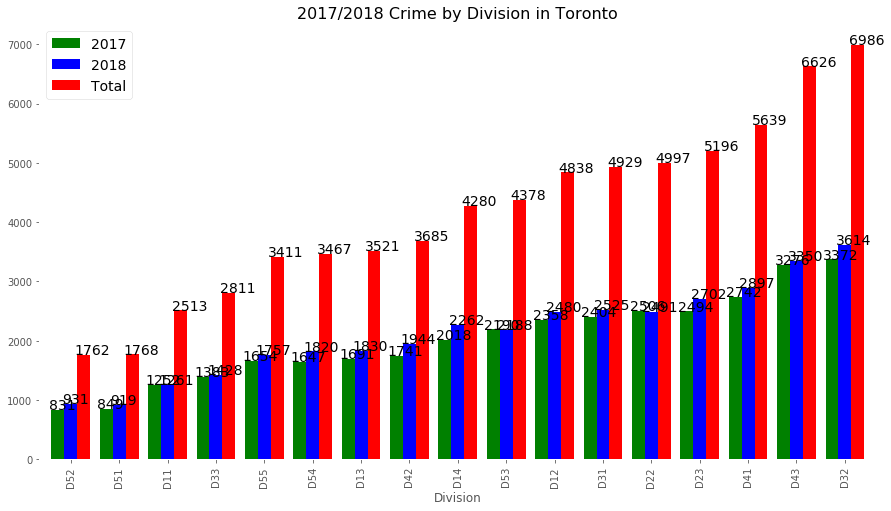

In [52]:
ax=sgddf.plot(kind='bar', figsize=(15, 8), color=['g','b','r'], width=0.8)

plt.title('2017/2018 Crime by Division in Toronto', fontsize=16)
legend = plt.legend(fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')

#plt.yticks([])
ax.set_facecolor('white')
for i in ax.patches:
    ax.text(i.get_x()-0.05, i.get_height()+10, \
            str(round(i.get_height(),2)), fontsize=14)
plt.show()

In [53]:
with open('.\Data\TorontoDivision.geojson') as geo_file:
    geo_data2 = json.load(geo_file)

## Plot Crime choropleth map of 2017-2018

### Found Top 3 safetest division

In [54]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, division in zip(ldf['LATITUDE'], ldf['LONGITUDE'], ldf['AREA_NAME']):
    labeltxt = '{}'.format(division)
    label = folium.Popup(labeltxt, parse_html=True)
    folium.map.Marker(
    [lat, lng],
    icon=DivIcon(
        icon_size=(80,20),
        icon_anchor=(10,10),
        html='<div style="font-size: 12pt"><strong>' + labeltxt + '</strong></div>',
        )
    ).add_to(toronto_map)
    
toronto_map.choropleth(geo_data=geo_data2,
    data = gddf_org,
    columns=['Division','Total'],
    key_on='feature.properties.Division',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.3,
    legend_name='Toronto Crime Rate by Division 2017-2018')
#m.save('Toronto_Crime_Division 2017-2018.html')
toronto_map

# Select Division 11
## Neighborhoods Analysis for D11

In [55]:
#!pip install pandas

import random # library for random number generation
import requests # library to handle requests

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed & Libraries imported.')

Folium installed & Libraries imported.


In [56]:
CLIENT_ID = 'Removed' # your Foursquare ID
CLIENT_SECRET = 'Removed' # your Foursquare Secret
ACCESS_TOKEN = 'Removed' #my Access Token
VERSION = '20180604'
LIMIT = 50

In [57]:
search_query = 'market'
radius = 1000
print(search_query + ' .... OK!')

market .... OK!


In [58]:
# D11 Center Location
dlat = 43.654151
dlong = -79.465607

In [59]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, dlat, dlong, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e437b2c6d8c56001b138ce2'},
 'response': {'venues': [{'id': '4e63b14ed164ddd5e64de7df',
    'name': 'T & M Fruit Market',
    'location': {'address': 'Bloor St W.',
     'crossStreet': 'at Dorval Rd.',
     'lat': 43.65612,
     'lng': -79.454538,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.65612,
       'lng': -79.454538}],
     'distance': 918,
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['Bloor St W. (at Dorval Rd.)',
      'Toronto ON',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d1fa941735',
      'name': 'Farmers Market',
      'pluralName': 'Farmers Markets',
      'shortName': "Farmer's Market",
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_farmersmarket_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1581480787',
    'hasPerk': False},
   {'id': '5529b34f498e37eed8a296d0',
    'name': 

In [60]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

id                        name  \
0  4e63b14ed164ddd5e64de7df          T & M Fruit Market   
1  5529b34f498e37eed8a296d0         Annette Food Market   
2  4b94043ef964a520a06134e3           Cathy Food Market   
3  4f089186e4b0ca3a5c693bfe       Blue Sky Fruit Market   
4  56898bc1498eaff1844f686a  Camaraderie Artisan Market   

                                          categories    referralId  hasPerk  \
0  [{'id': '4bf58dd8d48988d1fa941735', 'name': 'F...  v-1581480787    False   
1  [{'id': '4bf58dd8d48988d110941735', 'name': 'I...  v-1581480787    False   
2  [{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...  v-1581480787    False   
3  [{'id': '4bf58dd8d48988d118951735', 'name': 'G...  v-1581480787    False   
4  [{'id': '4bf58dd8d48988d127951735', 'name': 'A...  v-1581480787    False   

         location.address    location.crossStreet  location.lat  location.lng  \
0             Bloor St W.           at Dorval Rd.     43.656120    -79.454538   
1          240 Annette St  Annette and Quebec Ave     43.662457    -79.470979   
2         1278 Bloor West               at Dorval     43.656198    -79.454198   
3  1574 Bloor Street West             Dorval Road     43.656113    -79.453789   
4        2241 Dundas St W            Roncesvalles     43.654105    -79.451625   

                             location.labeledLatLngs  location.distance  \
0  [{'label': 'display', 'lat': 43.65612, 'lng': ...                918   
1  [{'label': 'display', 'lat': 43.66245651654667...               1020   
2  [{'label': 'display', 'lat': 43.65619830541318...                946   
3  [{'label': 'display', 'lat': 43.6561132943557,...                976   
4  [{'label': 'display', 'lat': 43.65410529937291...               1126   

  location.cc location.city location.state location.country  \
0          CA       Toronto             ON           Canada   
1          CA       Toronto             ON           Canada   
2          CA       Toronto             ON           Canada   
3          CA       Toronto             ON           Canada   
4          CA       Toronto             ON           Canada   

                           location.formattedAddress location.postalCode  \
0  [Bloor St W. (at Dorval Rd.), Toronto ON, Canada]                 NaN   
1  [240 Annette St (Annette and Quebec Ave), Toro...             M6P 1R1   
2  [1278 Bloor West (at Dorval), Toronto ON M6P 2...             M6P 2B2   
3  [1574 Bloor Street West (Dorval Road), Toronto...                 NaN   
4  [2241 Dundas St W (Roncesvalles), Toronto ON M...             M6R 1E6   

  location.neighborhood  
0                   NaN  
1              Junction  
2                   NaN  
3                   NaN  
4                   NaN

In [61]:
dataframe.to_csv('.\Data\Market.csv')

In [62]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

name           categories  \
0                 T & M Fruit Market       Farmers Market   
1                Annette Food Market   Italian Restaurant   
2                  Cathy Food Market    Food & Drink Shop   
3              Blue Sky Fruit Market        Grocery Store   
4         Camaraderie Artisan Market  Arts & Crafts Store   
5                           S Market   Miscellaneous Shop   
6   the Junction Flea Holiday Market          Flea Market   
7                       Night Market     Asian Restaurant   
8           Green Thumb Fruit Market        Grocery Store   
9           Junction Farmers' Market          Flea Market   
10        Toronto Internet Marketing               Office   

                   address                     crossStreet        lat  \
0              Bloor St W.                   at Dorval Rd.  43.656120   
1           240 Annette St          Annette and Quebec Ave  43.662457   
2          1278 Bloor West                       at Dorval  43.656198   
3   1574 Bloor Street West                     Dorval Road  43.656113   
4         2241 Dundas St W                    Roncesvalles  43.654105   
5    429 Roncesvalles Ave.                             NaN  43.651903   
6                      NaN                             NaN  43.665521   
7                      NaN                             NaN  43.665462   
8       2281 Bloor St West                     at Durie St  43.650776   
9                      NaN                             NaN  43.665487   
10        350A Wallace Ave  btw Perth Ave & Dundas St West  43.659955   

          lng                                     labeledLatLngs  distance  \
0  -79.454538  [{'label': 'display', 'lat': 43.65612, 'lng': ...       918   
1  -79.470979  [{'label': 'display', 'lat': 43.66245651654667...      1020   
2  -79.454198  [{'label': 'display', 'lat': 43.65619830541318...       946   
3  -79.453789  [{'label': 'display', 'lat': 43.6561132943557,...       976   
4  -79.451625  [{'label': 'display', 'lat': 43.65410529937291...      1126   
5  -79.450861  [{'label': 'display', 'lat': 43.65190257545597...      1213   
6  -79.465763  [{'label': 'display', 'lat': 43.665521, 'lng':...      1265   
7  -79.468469  [{'label': 'display', 'lat': 43.66546249480930...      1280   
8  -79.477933  [{'label': 'display', 'lat': 43.65077612663208...      1061   
9  -79.468118  [{'label': 'display', 'lat': 43.66548662830448...      1277   
10 -79.453837  [{'label': 'display', 'lat': 43.65995468, 'lng...      1147   

    cc     city state country  \
0   CA  Toronto    ON  Canada   
1   CA  Toronto    ON  Canada   
2   CA  Toronto    ON  Canada   
3   CA  Toronto    ON  Canada   
4   CA  Toronto    ON  Canada   
5   CA  Toronto    ON  Canada   
6   CA      NaN   NaN  Canada   
7   CA  Toronto    ON  Canada   
8   CA  Toronto    ON  Canada   
9   CA  Toronto    ON  Canada   
10  CA  Toronto    ON  Canada   

                                     formattedAddress postalCode neighborhood  \
0   [Bloor St W. (at Dorval Rd.), Toronto ON, Canada]        NaN          NaN   
1   [240 Annette St (Annette and Quebec Ave), Toro...    M6P 1R1     Junction   
2   [1278 Bloor West (at Dorval), Toronto ON M6P 2...    M6P 2B2          NaN   
3   [1574 Bloor Street West (Dorval Road), Toronto...        NaN          NaN   
4   [2241 Dundas St W (Roncesvalles), Toronto ON M...    M6R 1E6          NaN   
5         [429 Roncesvalles Ave., Toronto ON, Canada]        NaN          NaN   
6                                            [Canada]        NaN          NaN   
7                                [Toronto ON, Canada]        NaN          NaN   
8   [2281 Bloor St West (at Durie St), Toronto ON ...    M6S 1N9          NaN   
9                                [Toronto ON, Canada]        NaN          NaN   
10  [350A Wallace Ave (btw Perth Ave & Dundas St W...    M6P 3P2          NaN   

                          id  
0   4e63b14ed164ddd5e64de7df  
1   5529b34f498e37eed8a296d0  
2   4b94043ef964a520a0

In [63]:
dataframe_filtered.name

0                   T & M Fruit Market
1                  Annette Food Market
2                    Cathy Food Market
3                Blue Sky Fruit Market
4           Camaraderie Artisan Market
5                             S Market
6     the Junction Flea Holiday Market
7                         Night Market
8             Green Thumb Fruit Market
9             Junction Farmers' Market
10          Toronto Internet Marketing
Name: name, dtype: object

In [64]:
venues_map = folium.Map(location=[dlat, dlong], zoom_start=13) # generate map centred around D11

# add a red circle marker to represent the D11
folium.features.CircleMarker(
    [dlat, dlong],
    radius=10,
    color='red',
    popup='D11',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Markets as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [65]:
venue_id = '4e63b14ed164ddd5e64de7df' # ID T & M Fruit Market
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
#url
result = requests.get(url).json()
#print(result['response']['venue'].keys())
result['response']['venue']

{'id': '4e63b14ed164ddd5e64de7df',
 'name': 'T & M Fruit Market',
 'contact': {},
 'location': {'address': 'Bloor St W.',
  'crossStreet': 'at Dorval Rd.',
  'lat': 43.65612,
  'lng': -79.454538,
  'labeledLatLngs': [{'label': 'display', 'lat': 43.65612, 'lng': -79.454538}],
  'cc': 'CA',
  'city': 'Toronto',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['Bloor St W. (at Dorval Rd.)', 'Toronto ON', 'Canada']},
 'canonicalUrl': 'https://foursquare.com/v/t--m-fruit-market/4e63b14ed164ddd5e64de7df',
 'categories': [{'id': '4bf58dd8d48988d1fa941735',
   'name': 'Farmers Market',
   'pluralName': 'Farmers Markets',
   'shortName': "Farmer's Market",
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_farmersmarket_',
    'suffix': '.png'},
   'primary': True},
  {'id': '4bf58dd8d48988d118951735',
   'name': 'Grocery Store',
   'pluralName': 'Grocery Stores',
   'shortName': 'Grocery Store',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/s

In [66]:
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

This venue has not been rated yet.


In [67]:
venue_id = '5529b34f498e37eed8a296d0' # ID Annette Food Market
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

result = requests.get(url).json()
try:
    print(result['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')

8.5


In [68]:
result['response']['venue']['tips']['count']

3

In [69]:
## Ka Chi Korean Restaurant Tips
limit = 20 # set limit to be greater than or equal to the total number of tips
url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e437acc1835dd001b54638f'},
 'response': {'tips': {'count': 3,
   'items': [{'id': '582405f51942be3c24af8587',
     'createdAt': 1478755829,
     'text': 'Perfect place with open fire stove, hand made pizza in front of you and a nice list of wines.',
     'type': 'user',
     'canonicalUrl': 'https://foursquare.com/item/582405f51942be3c24af8587',
     'photo': {'id': '58247b3c7c74e13e29d1e9c8',
      'createdAt': 1478785852,
      'source': {'name': 'Foursquare for Android',
       'url': 'https://foursquare.com/download/#/android'},
      'prefix': 'https://fastly.4sqi.net/img/general/',
      'suffix': '/27930470_YtmI_IZ-r5h3nA--HzWxETkEAjcGbkMKcHQT7JTlvBY.jpg',
      'width': 5216,
      'height': 2934,
      'visibility': 'public'},
     'photourl': 'https://fastly.4sqi.net/img/general/original/27930470_YtmI_IZ-r5h3nA--HzWxETkEAjcGbkMKcHQT7JTlvBY.jpg',
     'lang': 'en',
     'likes': {'count': 0, 'groups': []},
     'logView': True,
     'agree

In [70]:
tips = results['response']['tips']['items']

tip = results['response']['tips']['items'][0]
tip.keys()

dict_keys(['id', 'createdAt', 'text', 'type', 'canonicalUrl', 'photo', 'photourl', 'lang', 'likes', 'logView', 'agreeCount', 'disagreeCount', 'todo', 'user', 'authorInteractionType'])

In [71]:
pd.set_option('display.max_colwidth', 0)

tips_df = json_normalize(tips) # json normalize tips

tips_df.head(1)

id   createdAt  \
0  582405f51942be3c24af8587  1478755829   

                                                                                            text  \
0  Perfect place with open fire stove, hand made pizza in front of you and a nice list of wines.   

   type                                          canonicalUrl  \
0  user  https://foursquare.com/item/582405f51942be3c24af8587   

                                                                                                photourl  \
0  https://fastly.4sqi.net/img/general/original/27930470_YtmI_IZ-r5h3nA--HzWxETkEAjcGbkMKcHQT7JTlvBY.jpg   

  lang  logView  agreeCount  disagreeCount  ... photo.height photo.visibility  \
0  en   True     0           0              ...  2934.0       public            

   likes.count likes.groups todo.count   user.id user.firstName  \
0  0            []           0          27930470  Ilya            

   user.lastName                  user.photo.prefix  \
0  K              https://fastly.4sqi.net/img/user/   

                user.photo.suffix  
0  /27930470-WWGRAM55IEU1LRQZ.jpg  

[1 rows x 28 columns]

In [72]:
# columns to keep
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id'] #, 'user.firstName', 'user.lastName' , 'user.gender', 'user.id']

tips_filtered = tips_df.loc[:, filtered_columns]

# display tips
tips_filtered

text  \
0  Perfect place with open fire stove, hand made pizza in front of you and a nice list of wines.                         
1  Sharing menu--share all the food! Except dessert, which comes in nice single portions that you won't want to share.   

   agreeCount  disagreeCount                        id  
0  0           0              582405f51942be3c24af8587  
1  0           0              55cff5dc498ef05aad8aaaf8

In [73]:
user_id = '81658' # user ID with most agree counts and complete profile

url = 'https://api.foursquare.com/v2/users/{}?&oauth_token={}&v={}'.format(user_id, ACCESS_TOKEN, VERSION) # define URL

# send GET request
results = requests.get(url).json()
user_data = results['response']['user']

# display features associated with user
user_data.keys()

dict_keys(['id', 'firstName', 'lastName', 'gender', 'canonicalUrl', 'photo', 'friends', 'tips', 'homeCity', 'bio', 'contact', 'superuser', 'photos', 'checkinPings', 'pings', 'type', 'mayorships', 'checkins', 'lists', 'blockedStatus', 'lenses'])

In [74]:
print('First Name: ' + user_data['firstName'])
print('Last Name: ' + user_data['lastName'])
print('Home City: ' + user_data['homeCity'])

First Name: Connie
Last Name: Crosby
Home City: Toronto, Canada


In [75]:
user_data['tips']

{'count': 161}

In [76]:
# define tips URL
url = 'https://api.foursquare.com/v2/users/{}/tips?client_id={}&client_secret={}&v={}&limit={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, VERSION, limit)

# send GET request and get user's tips
results = requests.get(url).json()
tips = results['response']['tips']['items']

# format column width
pd.set_option('display.max_colwidth', 0)

tips_df = json_normalize(tips)

# filter columns
filtered_columns = ['text', 'agreeCount', 'disagreeCount', 'id']
tips_filtered = tips_df.loc[:, filtered_columns]

# display user's tips
tips_filtered

text  \
0   Great write-up from the Globe & Mail (Oct 2015) http://www.theglobeandmail.com/news/toronto/meet-torontos-new-masters-of-the-pizza/article26760501/       
1   Try the ceviche--delicious                                                                                                                                
2   Friendly & fast service. Great price for passport photos. Centrally located at Yonge & Bloor in the underground path.                                     
3   The statue of Canadian poet Al Purdy is on the northeast side of the park. It has its own Twitter account! @statueofalpurdy                               
4   Sharing menu--share all the food! Except dessert, which comes in nice single portions that you won't want to share.                                       
5   Everything!                                                                                                                                               
6   Amazing food. Lobster roll is generous and very tasty. Highly recommend Taco Tuesdays. Pleasantly surprised by how delicious the cauliflower tacos are.   
7   Coffee (machines) and restrooms are downstairs                                                                                                            
8   Gift shop now open! Books, notebooks, T-shirts and other great swag.                                                                                      
9   Not impressed with the service here: uneven when I am with friends; not well served when a single diner. I have stopped eating here.                      
10  Line ups for the bar too long? There is a refreshments counter by the front door beside the box office, usually without a line up.                        
11  The Local is delicious--very fresh and lots of lobster.                                                                                                   
12  Light hiking and cycling. Quiet trails. Friendly people along the way.                                                                                    
13  Salt cod cakes at the back! Tasty.                                                                                                                        
14  Seafood taco. 4 types of shellfish. Homemade guacamole. Try it with Frank's hot sauce.                                                                    
15  President's Choice Black Label are handing out samples of their spicy grilled shrimp recipe. Very tasty.                                                  
16  Salads are very popular. The half size salads are huge.                                                                                                   
17  From the same people who own brewpub Gahan House across the street.                                                                                       
18  Taxi prices are flat rate. To downtown from the airport is currently $12.                                                                                 
19  They have stronger wifi than the open airport wifi. Ask the cashier for the password.                                                                     

    agreeCount  disagreeCount                        id  
0   0           0              5693f58f498ec50b041f5077  
1   0           0              564bf75e498eb8f11c995e93  
2   0           0              560c60ab498efa606c8bf15f  
3   1           0              56007063498ea624b41111c6  
4   0           0              55cff5dc498ef05aad8aaaf8  
5   0           0              55bd9d72498ea92c40bec1c1  
6   0           0              55b81c36498ebb77256f2b44  
7   0           0              54e58e5411d24eafa5b5f743  
8   0           0              54a1aef7498eb9647dbd0e19  
9   0           0              549ffb4a498ec41097d13129  
10  0           0              5430a31d498e0de35927e81c  
11  3           0              5421b213498efc42fb053fdf  
12  0           0              541f39d2498eeb6b139a5fff  

In [77]:
tip_id = '5421b213498efc42fb053fdf' # tip id

# define URL
url = 'http://api.foursquare.com/v2/tips/{}?client_id={}&client_secret={}&v={}'.format(tip_id, CLIENT_ID, CLIENT_SECRET, VERSION)

# send GET Request and examine results
result = requests.get(url).json()
print(result['response']['tip']['venue']['name'])
print(result['response']['tip']['venue']['location'])

Dave's Lobster Charlottetown
{'address': '1 Great George Street', 'crossStreet': 'Water Street', 'lat': 46.231947141745735, 'lng': -63.122943341732025, 'labeledLatLngs': [{'label': 'display', 'lat': 46.231947141745735, 'lng': -63.122943341732025}], 'postalCode': 'C1A 4J8', 'cc': 'CA', 'city': 'Charlottetown', 'state': 'PE', 'country': 'Canada', 'formattedAddress': ['1 Great George Street (Water Street)', 'Charlottetown PE C1A 4J8', 'Canada']}


In [78]:
user_friends = json_normalize(user_data['friends']['groups'][0]['items'])
user_friends

Empty DataFrame
Columns: []
Index: []

In [79]:
user_data

{'id': '81658',
 'firstName': 'Connie',
 'lastName': 'Crosby',
 'gender': 'female',
 'canonicalUrl': 'https://foursquare.com/user/81658',
 'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
  'suffix': '/QUSYGR2WOK4CHRET.jpg'},
 'friends': {'count': 172,
  'groups': [{'type': 'friends',
    'name': 'Mutual friends',
    'count': 0,
    'items': []},
   {'type': 'others',
    'name': 'Other friends',
    'count': 172,
    'items': [{'id': '72759729',
      'firstName': 'Doreen',
      'lastName': 'Iannuzzi',
      'gender': 'female',
      'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
       'suffix': '/72759729-NTVXT5XVXSIHBTT0.jpg'},
      'tips': {'count': 0},
      'lists': {'groups': [{'type': 'created', 'count': 2, 'items': []}]},
      'homeCity': 'Toronto, ON',
      'bio': '',
      'contact': {'facebook': '635567268'}},
     {'id': '40432',
      'firstName': 'Sam',
      'lastName': 'Dal Monte',
      'gender': 'male',
      'photo': {'prefix': 'https://fastl

In [80]:
Image(url='https://igx.4sqi.net/img/user/300x300/72759729-NTVXT5XVXSIHBTT0.jpg')

In [81]:
# Annette Food Market
latitude = 43.662457
longitude = -79.470979

In [82]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
import requests
results = requests.get(url).json()
'There are {} around Annette Food Market.'.format(len(results['response']['groups'][0]['items']))

'There are 50 around Annette Food Market.'

In [83]:
items = results['response']['groups'][0]['items']
items[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4bb3618514cfd13aa2ee15ab',
  'name': 'The Good Neighbour',
  'location': {'address': '238 Annette St',
   'crossStreet': 'at Quebec Ave.',
   'lat': 43.66257807131982,
   'lng': -79.4709859073286,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.66257807131982,
     'lng': -79.4709859073286}],
   'distance': 13,
   'postalCode': 'M6P 1R1',
   'cc': 'CA',
   'neighborhood': 'High P',
   'city': 'Toronto',
   'state': 'ON',
   'country': 'Canada',
   'formattedAddress': ['238 Annette St (at Quebec Ave.)',
    'Toronto ON M6P 1R1',
    'Canada']},
  'categories': [{'id': '4bf58dd8d48988d16d941735',
    'name': 'Café',
    'pluralName': 'Cafés',
    'shortName': 'Café',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'group

In [84]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head(10)

name          categories               address  \
0  The Good Neighbour      Café                238 Annette St         
1  Annette Food Market     Italian Restaurant  240 Annette St         
2  The Sweet Potato        Grocery Store       2995 Dundas St. W.     
3  Ice Cream Junction      Ice Cream Shop      3103 Dundas St W       
4  Curry Twist             Indian Restaurant   3034 Dundas St. West   
5  famous last words       Speakeasy           392 pacific ave        
6  When the Pig Came Home  Deli / Bodega       3035 Dundas St W       
7  nodo                    Italian Restaurant  2885 Dundas St. West   
8  Indie Alehouse          Gastropub           2876 Dundas St W       
9  Hole in the Wall        Bar                 2867 Dundas St W       

              crossStreet        lat        lng  \
0  at Quebec Ave.          43.662578 -79.470986   
1  Annette and Quebec Ave  43.662457 -79.470979   
2  at Pacific Ave          43.665405 -79.469229   
3  NaN                     43.665529 -79.473053   
4  High Park Ave.          43.665581 -79.470541   
5  Dundas St W             43.665181 -79.468471   
6  NaN                     43.665477 -79.470651   
7  NaN                     43.665303 -79.465621   
8  at Keele St             43.665475 -79.465290   
9  at Keele St             43.665296 -79.465118   

                                                                 labeledLatLngs  \
0  [{'label': 'display', 'lat': 43.66257807131982, 'lng': -79.4709859073286}]     
1  [{'label': 'display', 'lat': 43.662456516546676, 'lng': -79.4709790090443}]    
2  [{'label': 'display', 'lat': 43.665405425838244, 'lng': -79.4692294738573}]    
3  [{'label': 'display', 'lat': 43.665529400721674, 'lng': -79.4730527902899}]    
4  [{'label': 'display', 'lat': 43.66558068434231, 'lng': -79.47054074311107}]    
5  [{'label': 'display', 'lat': 43.665181, 'lng': -79.468471}]                    
6  [{'label': 'display', 'lat': 43.66547728416018, 'lng': -79.47065053444993}]    
7  [{'label': 'display', 'lat': 43.665303321627505, 'lng': -79.46562068004896}]   
8  [{'label': 'display', 'lat': 43.66547472315272, 'lng': -79.46528973047275}]    
9  [{'label': 'display', 'lat': 43.66529624102518, 'lng': -79.46511783107383}]    

   distance postalCode  cc                    neighborhood     city state  \
0  13        M6P 1R1    CA  High P                          Toronto  ON     
1  0         M6P 1R1    CA  Junction                        Toronto  ON     
2  357       M6P 1Z4    CA  The Junction                    Toronto  ON     
3  380       M6P        CA  NaN                             Toronto  ON     
4  349       NaN        CA  NaN                             Toronto  ON     
5  364       M6P        CA  Junction Triangle, Toronto, ON  Toronto  ON     
6  337       M6P 1Z5    CA  NaN                             Toronto  ON     
7  535       NaN        CA  NaN                             Toronto  ON     
8  568       M6P 1Y9    CA  The Junction                    Toronto  ON     
9  568       M6P 1Y9    CA  The Junction                    Toronto  ON     

  country  \
0  Canada   
1  Canada   
2  Canada   
3  Canada   
4  Canada   
5  Canada   
6  Canada   
7  Canada   
8  Canada   
9  Canada   

                                                        formattedAddress  \
0  [238 Annette St (at Quebec Ave.), Toronto ON M6P 1R1, Canada]           
1  [240 Annette St (Annette and Quebec Ave), Toronto ON M6P 1R1, Canada]   
2  [2995 Dundas St. W. (at Pacific Ave), Toronto ON M6P 1Z4, Canada]       
3  [3103 Dundas St W, Toronto ON M6P, Canada]                              
4  [3034 Dundas St. West (High Park Ave.), Toronto ON, Canada]             
5  [392 pacific ave (Dundas St W), Toronto ON M6P, Canada]                 
6  [3035 Dundas St W, Toronto ON M6P 1Z5, Canada]                          
7  [2885 Dundas St. West, Toronto ON, Canada]                              
8  [2876 Dundas St W (at Keele St), Toronto ON M6P 1Y9, Canada]            
9  [2867 Du

In [85]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco


# add Ecco as a red circle mark
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='Ka Chi Korean Restaurant',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

In [86]:
# define URL
url = 'https://api.foursquare.com/v2/venues/trending?client_id={}&client_secret={}&ll={},{}&v={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION)

# send GET request and get trending venues
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e437bc6d03993001bb0fdb1'},
 'response': {'venues': []}}

In [87]:
if len(results['response']['venues']) == 0:
    trending_venues_df = 'No trending venues are available at the moment!'
    
else:
    trending_venues = results['response']['venues']
    trending_venues_df = json_normalize(trending_venues)

    # filter columns
    columns_filtered = ['name', 'categories'] + ['location.distance', 'location.city', 'location.postalCode', 'location.state', 'location.country', 'location.lat', 'location.lng']
    trending_venues_df = trending_venues_df.loc[:, columns_filtered]

    # filter the category for each row
    trending_venues_df['categories'] = trending_venues_df.apply(get_category_type, axis=1)

In [88]:
# display trending venues
trending_venues_df

'No trending venues are available at the moment!'